In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import keras
import tensorflow as tf
import joblib
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


gpus= tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:

class RawData():
    def __init__(self, fname, sort=True, cut=True, sortcol='total', datasize=20000):
        self.df = pd.read_csv(fname)

        if(sort == True):
            self.df = self.df.sort_values(by=[sortcol], ascending=False).reset_index(drop=True)
        if(cut == True):
            self.df = self.df.iloc[:datasize]
        self.onehotmtx = onehot_coder_50(self.df, self.get_seqs())

    def get_df(self):
        return self.df

    def get_seqs(self):
        return self.df['utr']

    def get_onehotmtxs(self):
        return self.onehotmtx

    def get_data_size(self):
        return len(self.df)

def onehot_coder_50(data,seqs):

    nuc_d = {'a': [1, 0, 0, 0], 'c': [0, 1, 0, 0], 'g': [0, 0, 1, 0], 't': [0, 0, 0, 1], 'n': [0, 0, 0, 0]}
    onehotmtx = np.empty([len(data),50,4])
    for i in range(len(data)):
        seq = seqs.iloc[i]  ## 序列
        seq = seq.lower()[:50]
        for n, x in enumerate(seq):
            onehotmtx[i][n] = np.array(nuc_d[x])
    return onehotmtx

def r2(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value ** 2


In [3]:
def show_model_performance(ytrue,ypred):
    print("R^2 on test set = {:.4f} ".format(r2(ytrue,ypred)))
    print("RMSE on test set = {:.4f} ".format(mean_squared_error(ytrue,ypred),squared=False))
    print("MAE on test set = {:.4f} ".format(mean_absolute_error(ytrue,ypred)))
    print("MAPE on test set = {:.4f} ".format(mean_absolute_percentage_error(ytrue,ypred)))


In [4]:
def draw_joint_fig(model, scaler, testdata, color="#6AB27B"):
    testdf = testdata.get_df()
    pred_labels = model.predict(testdata.get_onehotmtxs())[1].reshape(-1)
    pred_labels = scaler.inverse_transform(pred_labels)
    testdf['pred'] = pred_labels
    
    ypred = testdf['pred'].to_numpy()
    ytrue = testdf['rl'].to_numpy()
    
    r_squared = r2(ytrue, ypred)

    with sns.axes_style("ticks"):
        ax = sns.jointplot(x=testdf['rl'], y=testdf['pred'], color=color,
                           marginal_kws = dict(bins = 20),
                           linewidth =0,
                           height =3,
                           ## kind='hex',
                           kind="scatter", joint_kws={"s":2},
                           xlim=(0, 9), ylim=(0, 9))

    ax.ax_joint.set_xticks([0, 2, 4, 6, 8])
    ax.ax_joint.set_yticks([0, 2, 4, 6, 8])
    ax.set_axis_labels("Observed MRL", "Predicted MRL", fontsize=12)
    ax.ax_joint.text(0.2, 0.2, "r²="+str(round(r_squared, 4)),size = 10)
    
    show_model_performance(ytrue,ypred)
    return ax

def draw_joint_fig_opt(model, scaler, testdata, color="#6AB27B"):
    testdf = testdata.get_df()
    pred_labels = model.predict(testdata.get_onehotmtxs()).reshape(-1)
    pred_labels = scaler.inverse_transform(pred_labels)
    testdf['pred'] = pred_labels
    
    ypred = testdf['pred'].to_numpy()
    ytrue = testdf['rl'].to_numpy()
    
    r_squared = r2(ytrue, ypred)
    
    with sns.axes_style("ticks"):
        ax = sns.jointplot(x=testdf['rl'], y=testdf['pred'], color=color,
                           marginal_kws = dict(bins = 20),
                           linewidth =0,
                           height =3,
                           ## kind='hex',
                           kind="scatter", joint_kws={"s":2},
                           xlim=(0, 9), ylim=(0, 9))

    ax.ax_joint.set_xticks([0, 2, 4, 6, 8])
    ax.ax_joint.set_yticks([0, 2, 4, 6, 8])
    ax.set_axis_labels("Observed MRL", "Predicted MRL", fontsize=12)
    ax.ax_joint.text(0.2, 0.2, "r²="+str(round(r_squared, 4)),size = 10)
    
    show_model_performance(ytrue,ypred)
    
    return ax

def draw_rf_fig():
    testdf = pd.read_csv("utr_RFregr_RNAfold_kmer.pred.csv")

    ypred = testdf["regr_pred"].to_numpy()
    ytrue = testdf["rl"].to_numpy()
    
    r_squared = r2(ytrue,ypred)
    color = "cornflowerblue"
    with sns.axes_style("ticks"):
        ax = sns.jointplot(x=testdf['rl'], y=testdf['regr_pred'], color=color,
                           marginal_kws = dict(bins = 20),
                           linewidth =0,
                           height =3,
                           ## kind='hex',
                           kind="scatter", joint_kws={"s":2},
                           xlim=(0, 9), ylim=(0, 9))

    ax.ax_joint.set_xticks([0, 2, 4, 6, 8])
    ax.ax_joint.set_yticks([0, 2, 4, 6, 8])
    ax.set_axis_labels("Observed MRL", "Predicted MRL", fontsize=12)
    ax.ax_joint.text(0.2, 0.2, "r²="+str(round(r_squared, 4)),size = 10)
    show_model_performance(ytrue,ypred)
    return ax

## MRL predictive performance of Smart5UTR 

R^2 on test set = 0.7911 
RMSE on test set = 0.3952 
MAE on test set = 0.4271 
MAPE on test set = 0.1015 


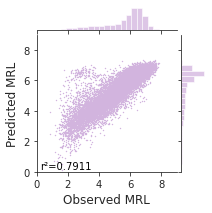

In [5]:
## load model
model = keras.models.load_model('../models/Auto-m1p/egfp_m1pseudo2_neck100_autoencoder_200k.h5')
scaler = joblib.load("../models/Auto-m1p/egfp_m1pseudo2_neck100_autoencoder_200k.scaler")
testdata_m1p = RawData("../../egfp_5UTRpseudo/data/GSM3130440_egfp_m1pseudo_2.csv", sort=True, cut=True, sortcol='total', datasize=20000)

## train on 5UTR-m1pseudo2 training set , validation on 5UTR-m1pseudo2 test set
## Smart5UTR
fig1 = draw_joint_fig(model, scaler, testdata_m1p, color="#D2B4DE")

R^2 on test set = 0.8178 
RMSE on test set = 0.6496 
MAE on test set = 0.6193 
MAPE on test set = 0.1334 


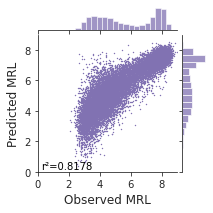

In [6]:

testdata_unmod = RawData("C:/Users/FloretLi/PycharmProjects/utrProject/data/GSM3130435_egfp_unmod_1.csv", sort=True, cut=True, sortcol='total_reads', datasize=20000)
scaler_unmod = joblib.load("C:/Users/FloretLi/PycharmProjects/utrProject/saved_models/unmodegfp_50nt_22w_sdScaler.save")

## train on 5UTR-m1pseudo2, test on 5UTR-unmod-egfp-test
## Smart5UTR
fig2 = draw_joint_fig(model, scaler_unmod, testdata_unmod, color="#8172B2")
fig2.savefig("../figs/prediction_autoencoder_egfp_unmod_1", dpi = 400)


## MRL predictive performance of Optimus 5-Prime


R^2 on test set = 0.7875 
RMSE on test set = 0.4286 
MAE on test set = 0.4522 
MAPE on test set = 0.1100 


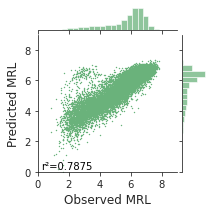

In [7]:

## load Optimus 5-Prime model and scaler
opt_scaler = joblib.load("../models/Optimus5-Prime/Optimus5_egfp_m1pseudo2_200k.scaler")
opt_model = keras.models.load_model('../models/Optimus5-Prime/Optimus5_egfp_m1pseudo2_model_200k_0.8.h5')


## train on 5UTR-m1pseudo2 training set , validation on 5UTR-m1pseudo2 test set
## Optimus 5-Prime model
fig3 = draw_joint_fig_opt(opt_model, opt_scaler, testdata_m1p, color="#6AB27B")
fig3.savefig("../figs/prediction_optm1p_egfp_m1pseudo_2", dpi = 400)

## MRL predictive performance of k-mer based Random Forest model


R^2 on test set = 0.4511 
RMSE on test set = 0.9755 
MAE on test set = 0.7009 
MAPE on test set = 0.1721 


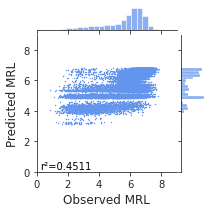

In [8]:

fig4 = draw_rf_fig()



### pearson correlation between RNA energy and MRL value

Pearson Correlation =  (0.15306913361976746, 4.064688257676339e-105)


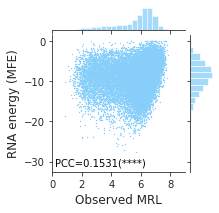

In [9]:
from scipy.stats import pearsonr


testdf = pd.read_csv("utr_RFregr_m1pseudo_2_MFE.testdata.csv")

mfe = testdf["energy_5utr"].to_numpy()
rl = testdf["rl"].to_numpy()

p_corre = pearsonr(mfe, rl)
print("Pearson Correlation = ", p_corre )

color = "lightskyblue"
with sns.axes_style("ticks"):
    ax = sns.jointplot(x=testdf['rl'], y=testdf['energy_5utr'], color=color,
                       marginal_kws = dict(bins = 20),
                       linewidth =0,
                       height =3,
                       ## kind='hex',
                       kind="scatter", joint_kws={"s":2},
                       xlim=(0, 9), 
#                        ylim=(0, 9)
                      )

ax.ax_joint.set_xticks([0, 2, 4, 6, 8])
# ax.ax_joint.set_yticks([0, 2, 4, 6, 8])
ax.set_axis_labels("Observed MRL", "RNA energy (MFE)", fontsize=12)
ax.ax_joint.text(0.2, -31, "PCC="+str(round(p_corre[0], 4))+"(****)",size = 10)
ax.savefig("../figs/MFE-MRL_egfp_m1pseudo_2", dpi = 400)